In [1]:
import pandas as pd
import pymongo
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용
import scipy
import scipy.stats as stats

client=pymongo.MongoClient("192.168.10.240",27017)
db= client['AI_LKJ']
collection_tour_pass_review = db['data_tour_pass_review']
data_tour_pass_review = collection_tour_pass_review.find()
df_tour_pass_review = pd.DataFrame(data_tour_pass_review)
collection_tour_pass_review_tmon = db['data_tour_pass_review_tmon']
data_tour_pass_review_tmon = collection_tour_pass_review_tmon.find()
df_tour_pass_review_tmon = pd.DataFrame(data_tour_pass_review_tmon)

## 데이터 확인 및 전처리

In [63]:
df_review = pd.concat(objs=[df_tour_pass_review,df_tour_pass_review_tmon])
df_review.head()

,_id,title,region,rating,date,content
0,663dea3806635b047a688c55,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.03.24.,남편과 갑작스럽게 가게 된 여수여행 둘다 여수는 처음이라 어디를 가야할지 무엇을 해...
1,663dea3806635b047a688c56,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,4,24.04.29.,저렴한 가격에 여러군데 둘러 볼수있어 좋았어요.\n다만 문을 일찍 닫거나 영업시간이...
2,663dea3806635b047a688c57,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.04.24.,아이들과함께 즐거운 여행하고 왔습니다. 사진보시면 어디어디 갔는지 알수있구요. 1...
3,663dea3806635b047a688c58,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.04.15.,아주 좋네요\n김경오파티쓰리에서 바다보며 아아 한잔 하고요...그닥 친절하진 않았어...
4,663dea3806635b047a688c59,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.05.02.,처음 이용해보았는데 가성비좋은것같습니다. 주말에이용하는데 체험하고 활동하는것은 주말...


In [64]:
# 결측치 확인
df_review.isnull().sum()

_id        0
title      0
region     0
rating     0
date       0
content    5
dtype: int64

In [65]:
# 결측치 제거
df_review = df_review.dropna()
df_review.isnull().sum()

_id        0
title      0
region     0
rating     0
date       0
content    0
dtype: int64

In [66]:
def datetime(text):
    text = text.replace('.', '')
    date = pd.to_datetime(text, format='%y%m%d')
    return date
df_review["datetime"] = df_review['date'].apply(datetime)
df_review

,_id,title,region,rating,date,content,datetime
0,663dea3806635b047a688c55,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.03.24.,남편과 갑작스럽게 가게 된 여수여행 둘다 여수는 처음이라 어디를 가야할지 무엇을 해...,2024-03-24
1,663dea3806635b047a688c56,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,4,24.04.29.,저렴한 가격에 여러군데 둘러 볼수있어 좋았어요.\n다만 문을 일찍 닫거나 영업시간이...,2024-04-29
2,663dea3806635b047a688c57,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.04.24.,아이들과함께 즐거운 여행하고 왔습니다. 사진보시면 어디어디 갔는지 알수있구요. 1...,2024-04-24
3,663dea3806635b047a688c58,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.04.15.,아주 좋네요\n김경오파티쓰리에서 바다보며 아아 한잔 하고요...그닥 친절하진 않았어...,2024-04-15
4,663dea3806635b047a688c59,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.05.02.,처음 이용해보았는데 가성비좋은것같습니다. 주말에이용하는데 체험하고 활동하는것은 주말...,2024-05-02
...,...,...,...,...,...,...,...
1040,663edc33cf0309091221da84,"[강원] 강릉제로패스\n하슬라아트월드,선교장 무료입장",강원,5,24.04.25.,너무 좋았습니다!! 매장마다 친절하셨고 커피도 맛있었어요,2024-04-25
1041,663edc33cf0309091221da85,"[강원] 강릉제로패스\n하슬라아트월드,선교장 무료입장",강원,5,24.04.18.,좋습니딘좋아요ㄲㅎㄲㄱ,2024-04-18
1042,663edc6111e8110b348ba7de,[주말에어디가] 전북투어패스\n남원춘향여행권,전북,5,24.03.24.,춘향테마파크가 운영을 안하고잇어서 아쉬웟네요,2024-03-24
1043,663edc6111e8110b348ba7df,[주말에어디가] 전북투어패스\n남원춘향여행권,전북,5,24.03.07.,저럄하게 이용했어요 ㅎㅎ,2024-03-07


## 연도별 투어패스 빈도수 분석

In [9]:
# 투어패스 연도별 빈도수
df_review["datetime"].dt.year.value_counts()

datetime
2022    10939
2023    10409
2024     3783
2021     3691
Name: count, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


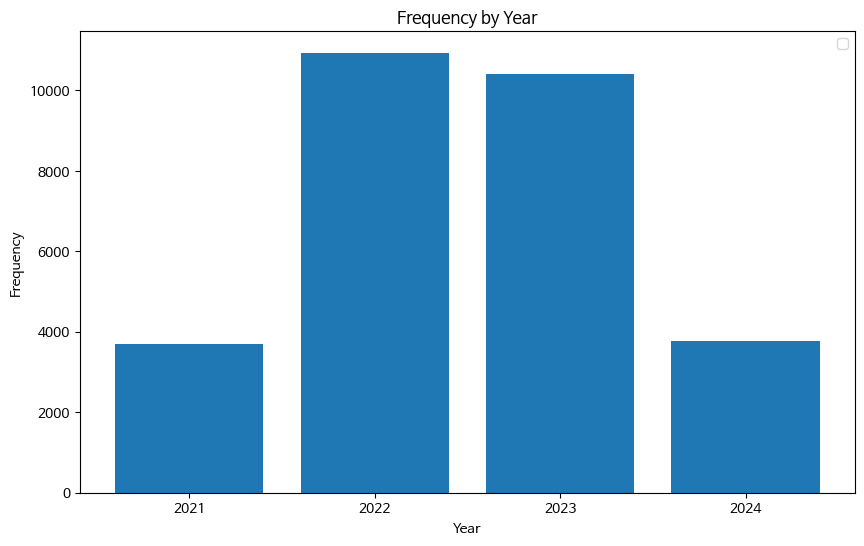

In [10]:
x = ["2021","2022","2023","2024"]
y = [len(df_review[df_review['datetime'].dt.year == 2021]),len(df_review[df_review['datetime'].dt.year == 2022]),len(df_review[df_review['datetime'].dt.year == 2023]),len(df_review[df_review['datetime'].dt.year == 2024])]
plt.figure(figsize=(10, 6))
plt.bar(x, y) 
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency by Year')
plt.legend() #범례
plt.show()

## 텍스트 분석

### 1. 감성분석 라벨링 텍스트 불러오기

In [11]:
# 텍스트 파일 경로
file_path = '../sample_labeling.txt'

# 텍스트 파일 읽기
with open(file_path, 'r') as file:
    read_data = file.read()

In [33]:
import pandas as pd
from io import StringIO
# 텍스트 데이터를 파일 객체로 변환
file_obj = StringIO(read_data)
file_obj
# 데이터프레임 생성
df_labeled = pd.read_csv(file_obj, sep='\t')
df_labeled

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
199995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
199996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
199997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
199998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [36]:
df_labeled.isnull().sum()

id          0
document    8
label       0
dtype: int64

In [40]:
df_labeled = df_labeled.dropna()
df_labeled

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
199995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
199996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
199997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
199998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


### 2. 훈련용,시험용 데이터셋 설정

In [41]:
from sklearn.model_selection import train_test_split
labeled_x = df_labeled['document']
labeled_y = df_labeled['label']
labeled_x_train,labeled_x_test = train_test_split(labeled_x,test_size=0.3,random_state=42)
labeled_y_train,labeled_y_test = train_test_split(labeled_y,test_size=0.3,random_state=42)

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,2))
labeled_x_train = tfidfVectorizer.fit_transform(labeled_x_train)
labeled_x_test = tfidfVectorizer.transform(labeled_x_test)
dictionary_list = tfidfVectorizer.get_feature_names_out()
dictionary_list

array(['00', '00 00', '00 각성하시길', ..., '不好', '不好 가을남산은참예쁘다', '紐⑦넗濡쒕씪異⑹쟾濡'],
      dtype=object)

### 3. 랜덤포레스트

In [43]:
from sklearn.ensemble import RandomForestClassifier
classification_topic = RandomForestClassifier(n_jobs=-1)
classification_topic.fit(labeled_x_train, labeled_y_train)

RandomForestClassifier(n_jobs=-1)

In [44]:
# classification_report로 model 성능 확인
labeled_y_train_predict = classification_topic.predict(labeled_x_train)
from sklearn.metrics import classification_report
print(classification_report(labeled_y_train, labeled_y_train_predict))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     69886
           1       0.99      1.00      0.99     70108

    accuracy                           0.99    139994
   macro avg       0.99      0.99      0.99    139994
weighted avg       0.99      0.99      0.99    139994



In [45]:
labeled_y_test_predict = classification_topic.predict(labeled_x_test)
from sklearn.metrics import classification_report
print(classification_report(labeled_y_test, labeled_y_test_predict))

              precision    recall  f1-score   support

           0       0.81      0.73      0.77     30110
           1       0.76      0.83      0.79     29888

    accuracy                           0.78     59998
   macro avg       0.78      0.78      0.78     59998
weighted avg       0.78      0.78      0.78     59998



### 4. 로지스틱 회귀분석

In [46]:
from sklearn import linear_model
logisticRegression=linear_model.LogisticRegression()
logisticRegression.fit(labeled_x_train,labeled_y_train)

LogisticRegression()

In [47]:
labeled_y_train_predict = logisticRegression.predict(labeled_x_train)
# classification_report로 model 성능 확인
from sklearn.metrics import classification_report
print(classification_report(labeled_y_train, labeled_y_train_predict))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     69886
           1       0.94      0.94      0.94     70108

    accuracy                           0.94    139994
   macro avg       0.94      0.94      0.94    139994
weighted avg       0.94      0.94      0.94    139994



In [48]:
labeled_y_test_predict = logisticRegression.predict(labeled_x_test)
from sklearn.metrics import classification_report
print(classification_report(labeled_y_test, labeled_y_test_predict))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81     30110
           1       0.82      0.78      0.80     29888

    accuracy                           0.81     59998
   macro avg       0.81      0.81      0.81     59998
weighted avg       0.81      0.81      0.81     59998



### 5. K 최근접 이웃

In [49]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(labeled_x_train, labeled_y_train)

KNeighborsClassifier()

In [50]:
labeled_y_train_predict = knn.predict(labeled_x_train)
# classification_report로 model 성능 확인
from sklearn.metrics import classification_report
print(classification_report(labeled_y_train, labeled_y_train_predict))

              precision    recall  f1-score   support

           0       0.74      0.64      0.69     69886
           1       0.68      0.78      0.73     70108

    accuracy                           0.71    139994
   macro avg       0.71      0.71      0.71    139994
weighted avg       0.71      0.71      0.71    139994



In [51]:
labeled_y_test_predict = knn.predict(labeled_x_test)
from sklearn.metrics import classification_report
print(classification_report(labeled_y_test, labeled_y_test_predict))

              precision    recall  f1-score   support

           0       0.59      0.47      0.52     30110
           1       0.56      0.66      0.61     29888

    accuracy                           0.57     59998
   macro avg       0.57      0.57      0.57     59998
weighted avg       0.57      0.57      0.56     59998



### 6. SVM

In [52]:
from sklearn import svm
svm_model = svm.SVC()
svm_model.fit(labeled_x_train, labeled_y_train)

SVC()

In [53]:
labeled_y_train_predict = svm_model.predict(labeled_x_train)
# classification_report로 model 성능 확인
from sklearn.metrics import classification_report
print(classification_report(labeled_y_train, labeled_y_train_predict))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     69886
           1       0.99      0.99      0.99     70108

    accuracy                           0.99    139994
   macro avg       0.99      0.99      0.99    139994
weighted avg       0.99      0.99      0.99    139994



In [54]:
labeled_y_test_predict = svm_model.predict(labeled_x_test)
from sklearn.metrics import classification_report
print(classification_report(labeled_y_test, labeled_y_test_predict))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81     30110
           1       0.80      0.85      0.82     29888

    accuracy                           0.82     59998
   macro avg       0.82      0.82      0.82     59998
weighted avg       0.82      0.82      0.82     59998



## 하이퍼 파라미터 적용 (시간관계상 생략함)

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
# from sklearn.datasets import load_iris

# # 탐색할 하이퍼파라미터 설정
# param_grid = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

# # 그리드 서치를 사용하여 최적의 하이퍼파라미터 탐색
# grid_search = GridSearchCV(logisticRegression, param_grid, cv=5)
# grid_search.fit(labeled_x_train, labeled_y_train)

# # 최적의 하이퍼파라미터 출력
# print("최적 하이퍼파라미터:", grid_search.best_params_)

# # 최적의 모델로 예측
# logistic_best_model = grid_search.best_estimator_       

In [ ]:
# labeled_y_test_predict = logistic_best_model.predict(labeled_x_test)
# from sklearn.metrics import classification_report
# print(classification_report(labeled_y_test, labeled_y_test_predict))

## 모델 선정 및 학습

정확성이 가장 높은 SVM 모델을 선정함

In [67]:
x_review = tfidfVectorizer.transform(df_review['content'])
df_review["sentiment"] = svm_model.predict(x_review)
df_review

,_id,title,region,rating,date,content,datetime,sentiment
0,663dea3806635b047a688c55,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.03.24.,남편과 갑작스럽게 가게 된 여수여행 둘다 여수는 처음이라 어디를 가야할지 무엇을 해...,2024-03-24,1
1,663dea3806635b047a688c56,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,4,24.04.29.,저렴한 가격에 여러군데 둘러 볼수있어 좋았어요.\n다만 문을 일찍 닫거나 영업시간이...,2024-04-29,0
2,663dea3806635b047a688c57,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.04.24.,아이들과함께 즐거운 여행하고 왔습니다. 사진보시면 어디어디 갔는지 알수있구요. 1...,2024-04-24,0
3,663dea3806635b047a688c58,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.04.15.,아주 좋네요\n김경오파티쓰리에서 바다보며 아아 한잔 하고요...그닥 친절하진 않았어...,2024-04-15,0
4,663dea3806635b047a688c59,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.05.02.,처음 이용해보았는데 가성비좋은것같습니다. 주말에이용하는데 체험하고 활동하는것은 주말...,2024-05-02,0
...,...,...,...,...,...,...,...,...
1040,663edc33cf0309091221da84,"[강원] 강릉제로패스\n하슬라아트월드,선교장 무료입장",강원,5,24.04.25.,너무 좋았습니다!! 매장마다 친절하셨고 커피도 맛있었어요,2024-04-25,1
1041,663edc33cf0309091221da85,"[강원] 강릉제로패스\n하슬라아트월드,선교장 무료입장",강원,5,24.04.18.,좋습니딘좋아요ㄲㅎㄲㄱ,2024-04-18,1
1042,663edc6111e8110b348ba7de,[주말에어디가] 전북투어패스\n남원춘향여행권,전북,5,24.03.24.,춘향테마파크가 운영을 안하고잇어서 아쉬웟네요,2024-03-24,1
1043,663edc6111e8110b348ba7df,[주말에어디가] 전북투어패스\n남원춘향여행권,전북,5,24.03.07.,저럄하게 이용했어요 ㅎㅎ,2024-03-07,1


=> 형태소 분석 이후 감성분석을 진행하였으나 그 과정에서 많은 텍스트가 처리되어 기존에 있는 텍스트로 분석함.

## 감성분석 적용 데이터 분석

### (1) 연도별 긍정과 부정의 비율

In [96]:
df_review

,_id,title,region,rating,date,content,datetime,sentiment
0,663dea3806635b047a688c55,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.03.24.,남편과 갑작스럽게 가게 된 여수여행 둘다 여수는 처음이라 어디를 가야할지 무엇을 해...,2024-03-24,1
1,663dea3806635b047a688c56,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,4,24.04.29.,저렴한 가격에 여러군데 둘러 볼수있어 좋았어요.\n다만 문을 일찍 닫거나 영업시간이...,2024-04-29,0
2,663dea3806635b047a688c57,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.04.24.,아이들과함께 즐거운 여행하고 왔습니다. 사진보시면 어디어디 갔는지 알수있구요. 1...,2024-04-24,0
3,663dea3806635b047a688c58,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.04.15.,아주 좋네요\n김경오파티쓰리에서 바다보며 아아 한잔 하고요...그닥 친절하진 않았어...,2024-04-15,0
4,663dea3806635b047a688c59,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.05.02.,처음 이용해보았는데 가성비좋은것같습니다. 주말에이용하는데 체험하고 활동하는것은 주말...,2024-05-02,0
...,...,...,...,...,...,...,...,...
1040,663edc33cf0309091221da84,"[강원] 강릉제로패스\n하슬라아트월드,선교장 무료입장",강원,5,24.04.25.,너무 좋았습니다!! 매장마다 친절하셨고 커피도 맛있었어요,2024-04-25,1
1041,663edc33cf0309091221da85,"[강원] 강릉제로패스\n하슬라아트월드,선교장 무료입장",강원,5,24.04.18.,좋습니딘좋아요ㄲㅎㄲㄱ,2024-04-18,1
1042,663edc6111e8110b348ba7de,[주말에어디가] 전북투어패스\n남원춘향여행권,전북,5,24.03.24.,춘향테마파크가 운영을 안하고잇어서 아쉬웟네요,2024-03-24,1
1043,663edc6111e8110b348ba7df,[주말에어디가] 전북투어패스\n남원춘향여행권,전북,5,24.03.07.,저럄하게 이용했어요 ㅎㅎ,2024-03-07,1


In [86]:
df_review["datetime"].dt.year.unique()

array([2024, 2023, 2022, 2021], dtype=int32)

In [97]:
print(len(df_review[df_review["datetime"].dt.year == 2021].query("sentiment == 1")),len(df_review[df_review["datetime"].dt.year == 2021].query("sentiment == 0")))
print(len(df_review[df_review["datetime"].dt.year == 2022].query("sentiment == 1")),len(df_review[df_review["datetime"].dt.year == 2022].query("sentiment == 0")))
print(len(df_review[df_review["datetime"].dt.year == 2023].query("sentiment == 1")),len(df_review[df_review["datetime"].dt.year == 2023].query("sentiment == 0")))
print(len(df_review[df_review["datetime"].dt.year == 2024].query("sentiment == 1")),len(df_review[df_review["datetime"].dt.year == 2024].query("sentiment == 0")))

3261 430
9274 1665
8743 1666
3144 639


In [167]:
list_year = ["2021", "2022", "2023", "2024"]
list_positive = [len(df_review[df_review["datetime"].dt.year == 2021].query("sentiment == 1"))
                 ,len(df_review[df_review["datetime"].dt.year == 2022].query("sentiment == 1"))
                      ,len(df_review[df_review["datetime"].dt.year == 2023].query("sentiment == 1"))
                      ,len(df_review[df_review["datetime"].dt.year == 2024].query("sentiment == 1"))]
list_negative = [len(df_review[df_review["datetime"].dt.year == 2021].query("sentiment == 0"))
                 ,len(df_review[df_review["datetime"].dt.year == 2022].query("sentiment == 0"))
                      ,len(df_review[df_review["datetime"].dt.year == 2023].query("sentiment == 0"))
                      ,len(df_review[df_review["datetime"].dt.year == 2024].query("sentiment == 0"))]

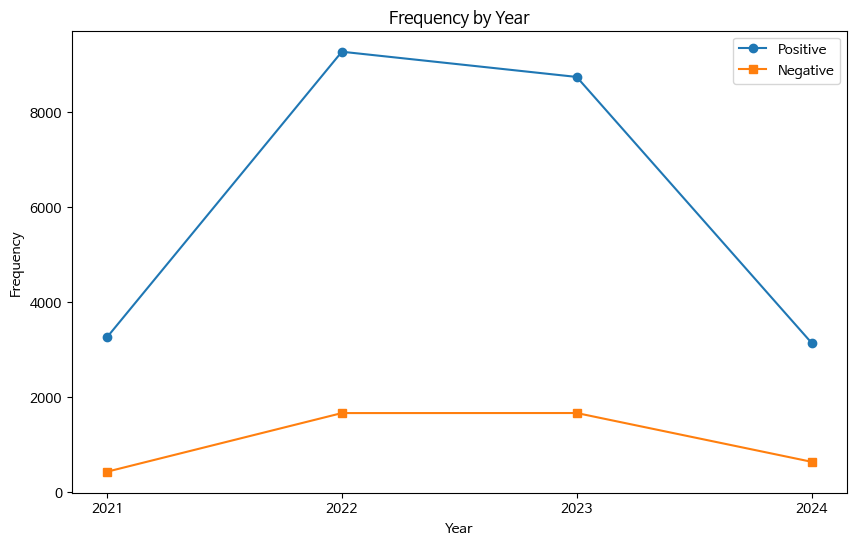

In [168]:
plt.figure(figsize=(10, 6))
plt.plot(list_year, list_positive, marker='o', label='Positive') 
plt.plot(list_year, list_negative, marker='s', label='Negative')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency by Year')
plt.legend() #범례
plt.show()

연도별로 긍정적인 리뷰가 부정적인 리뷰에 비해 압도적으로 많음.

### (2) 별점별 토픽 키워드 추출
- 긍정적인 토픽들은 마케팅 방안으로 사용하기 위함
- 부정적인 토픽들에 대한 개선점을 찾고 보완하기 위함

In [176]:
df_review

,_id,title,region,rating,date,content,datetime,sentiment,content_clean
0,663dea3806635b047a688c55,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.03.24.,남편과 갑작스럽게 가게 된 여수여행 둘다 여수는 처음이라 어디를 가야할지 무엇을 해...,2024-03-24,1,남편 가게 여수 여행 여수 처음 어디 가야 무엇 발견 여 수 투어 패스 덕분 여행 ...
1,663dea3806635b047a688c56,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,4,24.04.29.,저렴한 가격에 여러군데 둘러 볼수있어 좋았어요.\n다만 문을 일찍 닫거나 영업시간이...,2024-04-29,0,가격 여러 군데 다만 문 일찍 영업 시간 제대로 표기 헛걸음 곳 좀 여러 명 경우 ...
2,663dea3806635b047a688c57,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.04.24.,아이들과함께 즐거운 여행하고 왔습니다. 사진보시면 어디어디 갔는지 알수있구요. 1...,2024-04-24,0,아이 들 여행 사진 보시 어디 어디 11 곳 하나 사진 커서 안 곳 그냥 순천 48...
3,663dea3806635b047a688c58,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.04.15.,아주 좋네요\n김경오파티쓰리에서 바다보며 아아 한잔 하고요...그닥 친절하진 않았어...,2024-04-15,0,아주 김경 오 파티 바다 아아 한잔 그닥 여기저기 구경 아이스크림 옥 아이스크림 투...
4,663dea3806635b047a688c59,여수투어패스 통합권 여수핫플패스 테디베어뮤지엄 녹테마레 크루즈 루지 모찌,전남,5,24.05.02.,처음 이용해보았는데 가성비좋은것같습니다. 주말에이용하는데 체험하고 활동하는것은 주말...,2024-05-02,0,처음 이용 가성 비 것 주말 에이 체험 활동 주말 용이 시간 좀 카페 쿠키 테디베어...
...,...,...,...,...,...,...,...,...,...
1040,663edc33cf0309091221da84,"[강원] 강릉제로패스\n하슬라아트월드,선교장 무료입장",강원,5,24.04.25.,너무 좋았습니다!! 매장마다 친절하셨고 커피도 맛있었어요,2024-04-25,1,매장 커피
1041,663edc33cf0309091221da85,"[강원] 강릉제로패스\n하슬라아트월드,선교장 무료입장",강원,5,24.04.18.,좋습니딘좋아요ㄲㅎㄲㄱ,2024-04-18,1,습 딘
1042,663edc6111e8110b348ba7de,[주말에어디가] 전북투어패스\n남원춘향여행권,전북,5,24.03.24.,춘향테마파크가 운영을 안하고잇어서 아쉬웟네요,2024-03-24,1,향 테마 파크 운영 안 웟 네
1043,663edc6111e8110b348ba7df,[주말에어디가] 전북투어패스\n남원춘향여행권,전북,5,24.03.07.,저럄하게 이용했어요 ㅎㅎ,2024-03-07,1,럄 하 이용


In [181]:
score_one = df_review.query("rating == 1")["content_clean"].to_list()
score_two = df_review.query("rating == 2")["content_clean"].to_list()
score_three = df_review.query("rating == 3")["content_clean"].to_list()
score_four = df_review.query("rating == 4")["content_clean"].to_list()
score_five = df_review.query("rating == 5")["content_clean"].to_list()

In [185]:
# 불용어 리스트 생성
stopwords = ['가', '고', '을', '를', '이', '는', '은']
from konlpy.tag import Okt

# Okt 형태소 분석기 인스턴스 생성
okt = Okt()

# 토크나이징 함수 정의
# 한글자 이상이고 명사인 단어만 추출
def tokenizer(raw, pos=["Noun"], stopword=stopwords):
    return [
        word for word, tag in okt.pos(
            raw, 
            norm=True,   
            stem=True    
            )
            if len(word) > 1 and tag in pos and word not in stopword

    ]

In [210]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenizer, use_idf=True)
features = vectorizer.fit_transform(score_one)
features.toarray()

from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=3, random_state=55) #인스턴스화 #n_components 토픽의 갯수
lda_model.fit(features) #교육
dictionary_list = vectorizer.get_feature_names_out()
lda_model.components_

topics_output = lda_model.transform(features)
df_topics_score = pd.DataFrame(data=topics_output)
df_topics_score['dominant_topic_number'] = np.argmax(topics_output, axis=1) #  "topics_output" 배열에서 각 행마다 최대값의 인덱스를 찾아 "dominant_topic_number" 열에 할당
df_topics_score['sentences'] = score_one
df_topics_score

## 상위 단어 추출
topics_list = list()
for topic in lda_model.components_:
    df_datas = [topic, dictionary_list]
    df_topics = pd.DataFrame(data=df_datas)
    df_topics= df_topics.T #T는 행과 열을 바꿈
    df_topics = df_topics.sort_values(0, ascending=False)
    # print(df_topics[:3])
    topics_text = ' '.join(df_topics[1].values[:10])# 시리즈 형식으로 출력 get values from series / index
    print(topics_text)
    topics_list.append(topics_text)
topics_list_add = [topics_list, ['Topic1', 'Topic2', 'Topic3']]
df_topics_score_one = pd.DataFrame(topics_list_add)
df_topics_score_one

/usr/local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


별로 구매 예약 업체 요트 추가 패스 카페 승마 탐라
체험 시간 패스 진짜 상품 투어 홍보 구매 제주도 구입
생각 사용 그냥 추가 예약 별로 이용 요금 요구 최악


,0,1,2
0,별로 구매 예약 업체 요트 추가 패스 카페 승마 탐라,체험 시간 패스 진짜 상품 투어 홍보 구매 제주도 구입,생각 사용 그냥 추가 예약 별로 이용 요금 요구 최악
1,Topic1,Topic2,Topic3


In [ ]:
pip install wordcloud

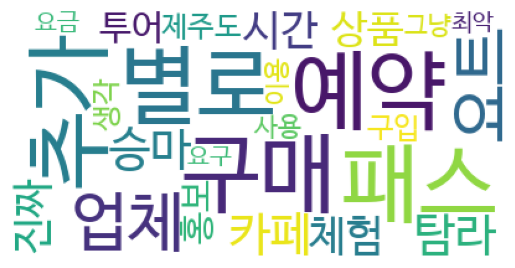

In [197]:
text = ",".join(topics_list)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", font_path = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
wordcloud.generate_from_text(text)  # 기존 text를 집어넣고 교육

import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off") #x,y축 범례를 없애줌
plt.show()

In [209]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenizer, use_idf=True)
features = vectorizer.fit_transform(score_two)
features.toarray()

from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=3, random_state=55) #인스턴스화 #n_components 토픽의 갯수
lda_model.fit(features) #교육
dictionary_list = vectorizer.get_feature_names_out()
lda_model.components_

topics_output = lda_model.transform(features)
df_topics_score = pd.DataFrame(data=topics_output)
df_topics_score['dominant_topic_number'] = np.argmax(topics_output, axis=1) #  "topics_output" 배열에서 각 행마다 최대값의 인덱스를 찾아 "dominant_topic_number" 열에 할당
df_topics_score['sentences'] = score_two
df_topics_score

## 상위 단어 추출
topics_list = list()
for topic in lda_model.components_:
    df_datas = [topic, dictionary_list]
    df_topics = pd.DataFrame(data=df_datas)
    df_topics= df_topics.T #T는 행과 열을 바꿈
    df_topics = df_topics.sort_values(0, ascending=False)
    # print(df_topics[:3])
    topics_text = ' '.join(df_topics[1].values[:10])# 시리즈 형식으로 출력 get values from series / index
    print(topics_text)
    topics_list.append(topics_text)
topics_list_add = [topics_list, ['Topic1', 'Topic2', 'Topic3']]
df_topics_score_two = pd.DataFrame(topics_list_add)
df_topics_score_two

/usr/local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


라이트 확인 관람 휴무 와인 동굴 관광 안내 곳도 가격
예약 이용 구매 여행 추가 사용 그냥 시간 패스 추천
생각 사용 그냥 별로 여행객 시간 예약 패스 정말 승마


,0,1,2
0,라이트 확인 관람 휴무 와인 동굴 관광 안내 곳도 가격,예약 이용 구매 여행 추가 사용 그냥 시간 패스 추천,생각 사용 그냥 별로 여행객 시간 예약 패스 정말 승마
1,Topic1,Topic2,Topic3


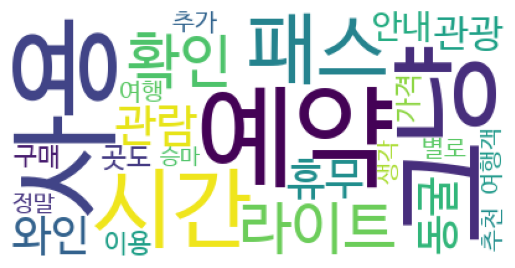

In [199]:
text = ",".join(topics_list)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", font_path = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
wordcloud.generate_from_text(text)  # 기존 text를 집어넣고 교육

import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off") #x,y축 범례를 없애줌
plt.show()

In [208]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenizer, use_idf=True)
features = vectorizer.fit_transform(score_three)
features.toarray()

from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=3, random_state=55) #인스턴스화 #n_components 토픽의 갯수
lda_model.fit(features) #교육
dictionary_list = vectorizer.get_feature_names_out()
lda_model.components_

topics_output = lda_model.transform(features)
df_topics_score = pd.DataFrame(data=topics_output)
df_topics_score['dominant_topic_number'] = np.argmax(topics_output, axis=1) #  "topics_output" 배열에서 각 행마다 최대값의 인덱스를 찾아 "dominant_topic_number" 열에 할당
df_topics_score['sentences'] = score_three
df_topics_score

## 상위 단어 추출
topics_list = list()
for topic in lda_model.components_:
    df_datas = [topic, dictionary_list]
    df_topics = pd.DataFrame(data=df_datas)
    df_topics= df_topics.T #T는 행과 열을 바꿈
    df_topics = df_topics.sort_values(0, ascending=False)
    # print(df_topics[:3])
    topics_text = ' '.join(df_topics[1].values[:10])# 시리즈 형식으로 출력 get values from series / index
    print(topics_text)
    topics_list.append(topics_text)
topics_list_add = [topics_list, ['Topic1', 'Topic2', 'Topic3']]
df_topics_score_three = pd.DataFrame(topics_list_add)
df_topics_score_three

/usr/local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


패스 투어 사용 상품 여러 활용 보고 체험 생각 제주
생각 사용 가성 추가 여행 별로 혜택 제주도 번창 계획
이용 예약 시간 그냥 아이 사용 커피 다음 카페 구매


,0,1,2
0,패스 투어 사용 상품 여러 활용 보고 체험 생각 제주,생각 사용 가성 추가 여행 별로 혜택 제주도 번창 계획,이용 예약 시간 그냥 아이 사용 커피 다음 카페 구매
1,Topic1,Topic2,Topic3


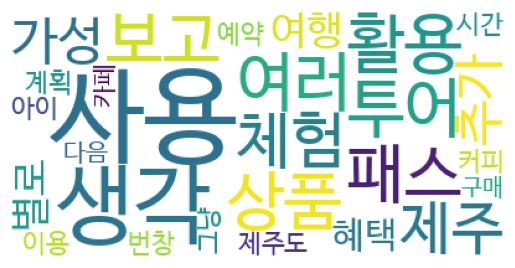

In [201]:
text = ",".join(topics_list)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", font_path = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
wordcloud.generate_from_text(text)  # 기존 text를 집어넣고 교육

import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off") #x,y축 범례를 없애줌
plt.show()

In [207]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenizer, use_idf=True)
features = vectorizer.fit_transform(score_four)
features.toarray()

from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=3, random_state=55) #인스턴스화 #n_components 토픽의 갯수
lda_model.fit(features) #교육
dictionary_list = vectorizer.get_feature_names_out()
lda_model.components_

topics_output = lda_model.transform(features)
df_topics_score = pd.DataFrame(data=topics_output)
df_topics_score['dominant_topic_number'] = np.argmax(topics_output, axis=1) #  "topics_output" 배열에서 각 행마다 최대값의 인덱스를 찾아 "dominant_topic_number" 열에 할당
df_topics_score['sentences'] = score_four
df_topics_score

## 상위 단어 추출
topics_list = list()
for topic in lda_model.components_:
    df_datas = [topic, dictionary_list]
    df_topics = pd.DataFrame(data=df_datas)
    df_topics= df_topics.T #T는 행과 열을 바꿈
    df_topics = df_topics.sort_values(0, ascending=False)
    # print(df_topics[:3])
    topics_text = ' '.join(df_topics[1].values[:10])# 시리즈 형식으로 출력 get values from series / index
    print(topics_text)
    topics_list.append(topics_text)
topics_list_add = [topics_list, ['Topic1', 'Topic2', 'Topic3']]
df_topics_score_four = pd.DataFrame(topics_list_add)
df_topics_score_four

/usr/local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


여행 패스 투어 제주 최고 카페 추가 구매 덕분 대비
사용 이용 가성 시간 여러 생각 다음 제주도 예약 군데
체험 가격 아주 정말 추천 아이 구경 커피 카페 활용


,0,1,2
0,여행 패스 투어 제주 최고 카페 추가 구매 덕분 대비,사용 이용 가성 시간 여러 생각 다음 제주도 예약 군데,체험 가격 아주 정말 추천 아이 구경 커피 카페 활용
1,Topic1,Topic2,Topic3


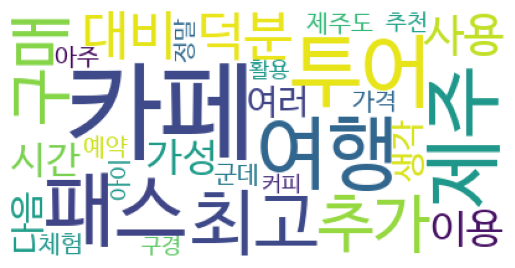

In [203]:
text = ",".join(topics_list)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", font_path = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
wordcloud.generate_from_text(text)  # 기존 text를 집어넣고 교육

import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off") #x,y축 범례를 없애줌
plt.show()

In [206]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenizer, use_idf=True)
features = vectorizer.fit_transform(score_five)
features.toarray()

from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=3, random_state=55) #인스턴스화 #n_components 토픽의 갯수
lda_model.fit(features) #교육
dictionary_list = vectorizer.get_feature_names_out()
lda_model.components_

topics_output = lda_model.transform(features)
df_topics_score = pd.DataFrame(data=topics_output)
df_topics_score['dominant_topic_number'] = np.argmax(topics_output, axis=1) #  "topics_output" 배열에서 각 행마다 최대값의 인덱스를 찾아 "dominant_topic_number" 열에 할당
df_topics_score['sentences'] = score_five
df_topics_score

## 상위 단어 추출
topics_list = list()
for topic in lda_model.components_:
    df_datas = [topic, dictionary_list]
    df_topics = pd.DataFrame(data=df_datas)
    df_topics= df_topics.T #T는 행과 열을 바꿈
    df_topics = df_topics.sort_values(0, ascending=False)
    # print(df_topics[:3])
    topics_text = ' '.join(df_topics[1].values[:10])# 시리즈 형식으로 출력 get values from series / index
    print(topics_text)
    topics_list.append(topics_text)
topics_list_add = [topics_list, ['Topic1', 'Topic2', 'Topic3']]
df_topics_score_five = pd.DataFrame(topics_list_add)
df_topics_score_five

/usr/local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


가성 여행 최고 패스 투어 추천 다음 완전 시간 구매
이용 아주 다음 정말 구경 무조건 구입 계획 무주 활용
사용 제주 아이 체험 덕분 제주도 카페 여러 커피 패스


,0,1,2
0,가성 여행 최고 패스 투어 추천 다음 완전 시간 구매,이용 아주 다음 정말 구경 무조건 구입 계획 무주 활용,사용 제주 아이 체험 덕분 제주도 카페 여러 커피 패스
1,Topic1,Topic2,Topic3


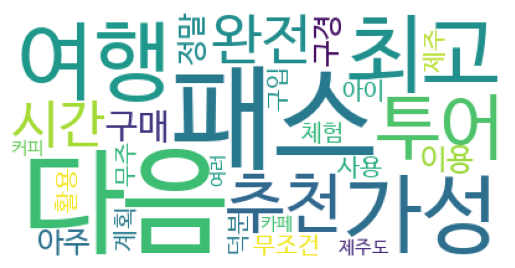

In [205]:
text = ",".join(topics_list)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", font_path = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
wordcloud.generate_from_text(text)  # 기존 text를 집어넣고 교육

import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off") #x,y축 범례를 없애줌
plt.show()

대체적으로 긍정적인 내용이 부정적인 내용보다 많았다.

## Reference

https://github.com/Seokii/Korean_NLP_Tutorial